# Plane wall

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cghiaus/var_cond/HEAD?labpath=notebooks%2F03_wall_steady.ipynb)

Let's consider a plane wall with variable conductivity included into a more complex model.  In this case, the surface temperatures are unknowns of the thermal network.

The __iterative method__ proposed for the case of variable conductivity is:

- Initially, consider conductances $G_{w0}$ in the wall calculated with conductivity $\lambda_0.$

- Assemble the thermal circuits considering $G_{w0}$: $G = \mathrm{diag} ([G_0, ..., G_{w0}, ..., G_n])$.

- Estimate the initial temperature distribution in the thermal network:

$$
\theta_0 = (A^T G A)^{-1}(A^T G b + f)
$$

- __While__ $\left \| \varepsilon \right \|_\infty > \varepsilon_{admitted}$, calculate:
    - $\bar \theta = f(\theta_0)$ mean temperatures for linear or quadratic model;
    - $G_w = \frac{1}{w/n_b} \lambda_0 (1 + \beta \bar \theta)$ conductances in the wall with variable conductivity;
    - $\theta = (A^T G A)^{-1}(A^T G b + f)$ temperatures in the circuit;
    - $\left \| \varepsilon \right \|_\infty ≡ \mathrm{max}(|\theta - \theta_0|)$ error between iterrations;
    - $\theta_0 \leftarrow  \theta$ new temperature distribution;
- $q = G (-A \theta + b)$ flow-rates in the circuit.

The flow rate through the wall is $q_1 = q_2 = ... = q_{n-1}$.


In order to exemplify this algorithm, let's consider a wall with convection and absorbed irradiance on both surfaces (Figure 1). The examples are for two materials, fiberglass and polyisocyanurate, which have linear and quadratic models for conductivity, respectively.

![therm_circ](./figures/var_cond_wall.svg)
> Figure 1. Thermal circuit for a plane wall with convection and flow-rate sources.

The simulation consists in:

- From the linear (polynomial) model, $\lambda = a T + b$, obtain the canonical conductivity model:

$$
\lambda = \lambda_0(1 + \beta (T - T_b))
$$

or 

$$
\lambda = \lambda_0(1 + \beta (T - T_b)^2)
$$

- Numerically solve the thermal circuit for the wall (i.e., find the temperatures and the flow rates).

- By using the temperatures for the surface of the wall (which were found numerically), solve analytically the Dirichlet problem.

- Plot on the same graph the temperature distribution obtained numerically and analytically, and a line between the surface temperatures.

In [1]:
import numpy as np
import sys
sys.path.append('../src')  # Add 'src' directory to the system path
import var_cond

## Linear model

Let's consider the fiberglass wall for which we can modify the width, the number of meshes for discretisation, the air temperatures, the irradiances and the convection coefficients on both sides of the wall, and the base temperature in the model of conductivity.

In [2]:
# Data
width = 0.20                # m, width of the plane wall in number of meshes
mesh = 3                    # number of meshes, mesh > 2
air_temp = -20, 20          # °C, air temperatures outdoor; indoor
flow_surf = 0, 0            # W/m², flow on surfaces outdoor, indoor
conv_coef = 8, 25           # W/(m·K²), convection coefficients outdoor, indoor

### Influence of base temperature

The flow rate through the wall in the case of constant conductivity and no flow rate sources on the surfaces is:

$$
q_m = U \Delta T_a
$$

where:
- $U = \frac{1}{\frac{1}{h_0} + \frac{w}{\lambda} + \frac{1}{h_1}}$ - global conductivity, W/(m²·K);
- $\Delta T_a = T_{a,0} - T_{a,1}$ - difference of air temperatures, °C.

For a base temperature $T_b$ = 20 °C, the relative error

$$
\varepsilon = \frac{q_m - q}{q}
$$

between using the constant conductivity $\lambda_0$ for estimating the flow rate, $q_m$ and by using numerical method to calculate the flow rate, $q$, is about 10 %.

Base temperature: 		 20.0 °C
Flow rate with variable λ: 	 -7.76 W/m²
Flow rate with constant λ0: 	 -8.49 W/m²
Relative error: 		 9.47 %


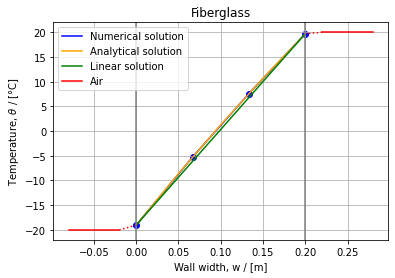

In [3]:
# Linear model
Tb = 20                     # °C, mean (base) temperature
# fitted λ(T) = a * T + b
conductivity_poly = 0.0002, 0.04
deg = 1
material = 'Fiberglass'

q, conductivity_model, surf_temp = var_cond.wall_sim(
    width, mesh,
    air_temp, flow_surf, conv_coef,
    Tb, conductivity_poly, deg,
    material)

λ0, β, Tb, deg = conductivity_model

U = 1 / (1 / conv_coef[0] + width / λ0 + 1 / conv_coef[1])
q_m = U * (air_temp[0] - air_temp[1])

ε = (q_m - q[1]) / q[1]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate with variable λ: \t {q[1]:.2f} W/m²')
print(f'Flow rate with constant λ0: \t {q_m:.2f} W/m²')
print(f'Relative error: \t\t {ε*100:.2f} %')

> Figure 2. Temperature distribution in a wall with linear thermal conductivity in the case of no irradiation of the surfaces. $T_b$ = 20 °C.

If the base temperature is the mean of air temperatures, the relative error is small.

Base temperature: 		 0.0 °C
Flow rate with variable λ: 	 -7.76 W/m²
Flow rate with constant λ0: 	 -7.74 W/m²
Relative error: 		 -0.16 %


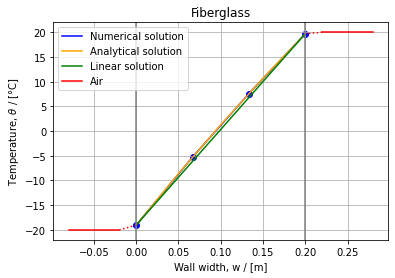

In [4]:
Tb = 0

q, conductivity_model, surf_temp = var_cond.wall_sim(
    width, mesh,
    air_temp, flow_surf, conv_coef,
    Tb, conductivity_poly, deg,
    material)
λ0, β, Tb, deg = conductivity_model

U = 1 /(1 / conv_coef[0] + width / λ0 + 1 / conv_coef[1])
q_m = U * (air_temp[0] - air_temp[1])

ε = (q_m - q[1]) / q[1]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate with variable λ: \t {q[1]:.2f} W/m²')
print(f'Flow rate with constant λ0: \t {q_m:.2f} W/m²')
print(f'Relative error: \t\t {ε*100:.2f} %')

> Figure 3. Temperature distribution in a wall with linear thermal conductivity in the case of no irradiation of the surfaces. $T_b$ = 0 °C.

If the base temperature is choses as the mean of surface temperatures, the error in estimating the flow rate by variable conductivity, $\lambda = \lambda_0 (1 + \beta (T - T_b))$,  or by constant conductivity, $\lambda_0$, is zero.

Base temperature: 		 0.3 °C
Flow rate with variable λ: 	 -7.76 W/m²
Flow rate with constant λ0: 	 -7.76 W/m²
Relative error: 		 -0.00 %


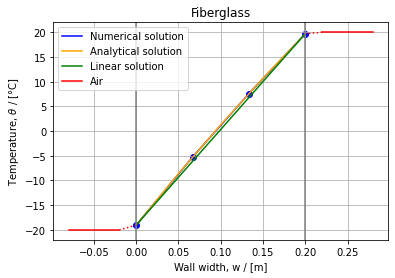

In [5]:
Tb = np.mean(surf_temp)

q, conductivity_model, surf_temp = var_cond.wall_sim(
    width, mesh,
    air_temp, flow_surf, conv_coef,
    Tb, conductivity_poly, deg,
    material)
λ0, β, Tb, deg = conductivity_model

U = 1 /(1 / conv_coef[0] + width / λ0 + 1 / conv_coef[1])
q_m = U * (air_temp[0] - air_temp[1])

ε = (q_m - q[1]) / q[1]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate with variable λ: \t {q[1]:.2f} W/m²')
print(f'Flow rate with constant λ0: \t {q_m:.2f} W/m²')
print(f'Relative error: \t\t {ε*100:.2f} %')

> Figure 4. Temperature distribution in a wall with linear thermal conductivity in the case of no irradiation of the surfaces. $T_b = (T_0 + T_1) / 2$.

### Influence of irradiance absorbed by the surfaces

The thermal circuit for the case of constant conductivity of the wall and flow rate sources on the surfaces is shown in Figure 5.

![therm_circ](./figures/const_cond_wall.svg)
> Figure 5. Thermal circuit for a plane wall with convection and flow-rate sources in the case of constant conductivity and absorbed irradiance on the surfaces.

The thermal circuit from Figure 5 is characterized by the matrices and vectors:

$$
A = \begin{bmatrix}
1 & 0 \\ 
-1 & 1 \\ 
0 & -1
\end{bmatrix} ;
G = \mathrm{diag} \begin{bmatrix}
h_0\\ 
\lambda_0/w\\ 
h_1
\end{bmatrix} ;
b = \begin{bmatrix}
T_{a,0}\\ 
0\\ 
-T_{a,1}
\end{bmatrix} ;
f = \begin{bmatrix}
\dot Q_0\\ 
\dot Q_1
\end{bmatrix}
$$

The solution of the system is

$$\left\{\begin{array}{ll}
\theta_m = (A^T G A)^{-1}(A^T G b + f) \\ 
q_m = G (-A \theta_m + b)
\end{array}\right.$$

The flow rate through the wall is $q_{m,1}$.

Base temperature: 		 20.0 °C
Flow rate with variable λ: 	 -3.94 W/m²
Flow rate with mean λ0: 	 -4.03 W/m²
Relative error: 		 2.40 %


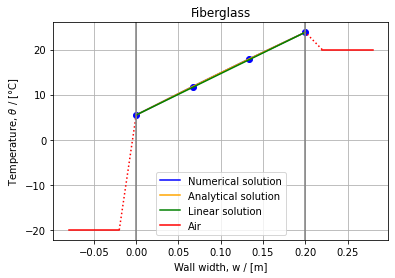

In [6]:
Tb = 20
air_temp = -20, 20
flow_surf = 200, 100 

q, conductivity_model, surf_temp = var_cond.wall_sim(
    width, mesh,
    air_temp, flow_surf, conv_coef,
    Tb, conductivity_poly, deg,
    material)
λ0, β, Tb, deg = conductivity_model

# Thermal circuit with constant conductivity λ0
A = np.array([[1, 0],
              [-1, 1],
              [0, -1]])
G = np.diag([conv_coef[0], λ0 / width, conv_coef[1]])
b = np.array([air_temp[0], 0, -air_temp[1]])
f = np.array([flow_surf[0], flow_surf[1]])

θ_m = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
q_m = G @ (-A @ θ_m + b)

ε = (q_m[1] - q[1]) / q[1]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate with variable λ: \t {q[1]:.2f} W/m²')
print(f'Flow rate with mean λ0: \t {q_m[1]:.2f} W/m²')
print(f'Relative error: \t\t {ε*100:.2f} %')

> Figure 6. Temperature distribution in a wall with linear thermal conductivity in the case of absorbed irradiation of the surfaces.

## Quadratic model

For the quadratic model, the base temperature $T_b$ results from the polynomial coefficients $a$, $b$, and $c$, i.e., it can be not chosen arbitrarily.

In [7]:
# Quadratic model
Tb = None                   # °C, mean (base) temperature

# fitted λ(T) = a·T² + b·T + c
conductivity_poly = 8.364e-06, -3.857e-04, 3.128e-02
deg = 2
material = 'Polyisocyanurate'

### Influence of the surface temperatures

The error introduced by estimating the flow rates by using constant conductivity $\lambda_0$ is smaller if the temperature range is smaller and if it is centred around the base temperature $T_b$.

Base temperature: 		 23.1 °C
Flow rate with variable λ: 	 -6.28 W/m²
Flow rate with mean λ0: 	 -5.25 W/m²
Relative error: 		 -16.40 %


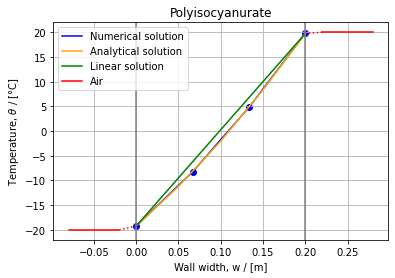

In [8]:
air_temp = -20, 20
flow_surf = 0, 0 

q, conductivity_model, surf_temp = var_cond.wall_sim(
    width, mesh,
    air_temp, flow_surf, conv_coef,
    Tb, conductivity_poly, deg,
    material)

λ0, β, Tb, deg = conductivity_model

A = np.array([[1, 0],
              [-1, 1],
              [0, -1]])
G = np.diag([conv_coef[0], λ0 / width, conv_coef[1]])
b = np.array([air_temp[0], 0, -air_temp[1]])
f = np.array([flow_surf[0], flow_surf[1]])

θ_m = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
q_m = G @ (-A @ θ_m + b)

ε = (q_m[1] - q[1]) / q[1]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate with variable λ: \t {q[1]:.2f} W/m²')
print(f'Flow rate with mean λ0: \t {q_m[1]:.2f} W/m²')
print(f'Relative error: \t\t {ε*100:.2f} %')

> Figure 7. Temperature distribution in a wall with quadratic thermal conductivity in the case of no irradiation of the surfaces. $T_b$ is imposed by the shape of the model fitted to experimental data.

Base temperature: 		 23.1 °C
Flow rate with variable λ: 	 -5.47 W/m²
Flow rate with mean λ0: 	 -5.25 W/m²
Relative error: 		 -3.96 %


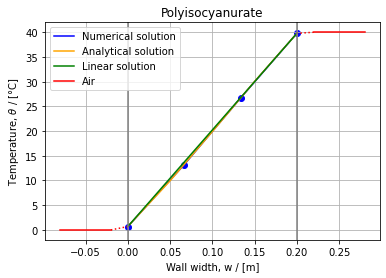

In [9]:
air_temp = Tb - 20, Tb + 20
air_temp = 0, 40
flow_surf = 0, 0 

q, conductivity_model, surf_temp = var_cond.wall_sim(
    width, mesh,
    air_temp, flow_surf, conv_coef,
    Tb, conductivity_poly, deg,
    material)

λ0, β, Tb, deg = conductivity_model

A = np.array([[1, 0],
              [-1, 1],
              [0, -1]])
G = np.diag([conv_coef[0], λ0 / width, conv_coef[1]])
b = np.array([air_temp[0], 0, -air_temp[1]])
f = np.array([flow_surf[0], flow_surf[1]])

θ_m = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
q_m = G @ (-A @ θ_m + b)

ε = (q_m[1] - q[1]) / q[1]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate with variable λ: \t {q[1]:.2f} W/m²')
print(f'Flow rate with mean λ0: \t {q_m[1]:.2f} W/m²')
print(f'Relative error: \t\t {ε*100:.2f} %')

> Figure 7. Temperature distribution in a wall with quadratic thermal conductivity in the case of no irradiation of the surfaces. Error is smaller if the temperature range is around $T_b$.

### Influence of irradiance absorbed by the surfaces

The thermal circuit for this case is shown in Figure 5. The irradiance absorbed by the surfaces reduce the range of temperature variation of the surfaces and hence the error induced by using constant conductivity. 

Base temperature: 		 23.1 °C
Flow rate with variable λ: 	 -2.57 W/m²
Flow rate with mean λ0: 	 -2.49 W/m²
Relative error: 		 -2.96 %


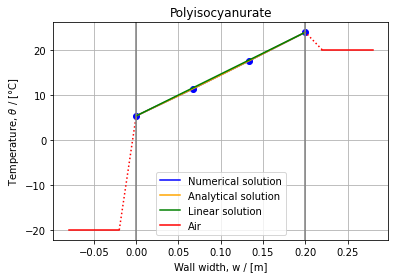

In [10]:
air_temp = -20, 20
flow_surf = 200, 100 

q, conductivity_model, surf_temp = var_cond.wall_sim(
    width, mesh,
    air_temp, flow_surf, conv_coef,
    Tb, conductivity_poly, deg,
    material)

λ0, β, Tb, deg = conductivity_model

A = np.array([[1, 0],
              [-1, 1],
              [0, -1]])
G = np.diag([conv_coef[0], λ0 / width, conv_coef[1]])
b = np.array([air_temp[0], 0, -air_temp[1]])
f = np.array([flow_surf[0], flow_surf[1]])

θ_m = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
q_m = G @ (-A @ θ_m + b)

ε = (q_m[1] - q[1]) / q[1]
print(f'Base temperature: \t\t {Tb:.1f} °C')
print(f'Flow rate with variable λ: \t {q[1]:.2f} W/m²')
print(f'Flow rate with mean λ0: \t {q_m[1]:.2f} W/m²')
print(f'Relative error: \t\t {ε*100:.2f} %')

> Figure 8. Temperature distribution in a wall with quadratic thermal conductivity in the case of absorbed irradiation of the surfaces.

## Conclusions

In the general case, the temperatures of the wall surfaces are not known. Therefore, the mean temperature $\bar{\theta}$, and hence the base tempetarture $T_b$ cannot be determined.

The base temperature can be chosen for linear model of variable conductivity; it is a result of the shape of the empirical data for the quadratic model of variable conductivity.

Choosing a base temperature $T_b$ (and consequently $\lambda_0$, near the mean of the surface temperatures reduces the error induced by using constant conductivity $\lambda_0$.

The flow rates on the wall surfaces reduce the range of temperature variation and, consequently, the error induced by using constant conductivity $\lambda_0$.